In [27]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import numpy as np
import matplotlib.pyplot as plt
import copy
import random

%matplotlib inline

import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [14]:
ls = []

dct = {i : i for i in range(10)}

ls.extend(dct.values())
print(ls)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [15]:
# define the transformation of the data. 
transform = transforms.Compose(
    [transforms.ToTensor(),     # convert the image to a pytorch tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalise the image with mean and std of 0.5

batch_size = 64     # define the batch size

trainset = CIFAR10(root='./data', train=True,
                   download=True, transform=transform)

# split the training set into 80% training and 20% validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size

train_dataset, val_dataset = random_split(trainset, [train_size, val_size]) #generate random training and validation sets

valloader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=0)

# load test data
testset = CIFAR10(root='./data', train=False,
                  download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=0)


# define classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [16]:
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()

        self.relu = nn.ReLU()               # activation function

        # convcolutional layers
        self.ConvLayers = nn.ModuleList([
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # N x 3 x 32 x 32 -> N x 32 x 32 x 32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # N x 32 x 16 x 16 -> N x 64 x 16 x 16
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # N x 64 x 8 x 8 -> N x 128 x 8 x 8
        ])

        # batch normalization layers (for regularization)
        self.BatchNorms = nn.ModuleList([
            nn.BatchNorm2d(32),
            nn.BatchNorm2d(64),
            nn.BatchNorm2d(128),
        ])

        self.fc1 = nn.Linear(128 * 4 * 4, 256)      # first fully connected layer after convolutional layers
        self.fc2 = nn.Linear(256, 10)               # final fully connected layer for output

        self.pool = nn.MaxPool2d(2, 2)      # max pooling layer for regularization
        self.dropout = nn.Dropout(0.2)      # dropout layer for regularization

    def forward(self, x):
        for conv, batchnorm in zip(self.ConvLayers, self.BatchNorms):
            # apply convolutional layer, then batch normalization, then ReLU, then max pooling
            x = batchnorm(conv(x))
            x = self.pool(self.relu(x))       # final shape: N x 128 x 4 x 4

        x = x.view(x.size(0), -1)       # reshape to N x 128*4*4
        x = self.relu(self.fc1(x))      # fully connected layer and ReLU
        x = self.dropout(x)             # apply dropout for regularization
        x = self.fc2(x)                 # final fully connected layer for output
        return x


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
net = SmallCNN().to(device)

trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Trainable parameters:", trainable_params)

init_weights = copy.deepcopy(net.state_dict())

device: cpu
Trainable parameters: 620810


In [17]:
class Client:
    '''
    Class that represents clients in a federated learning system.
    The client should maintain a fixed local dataset, and
    contain a method that can be called to train the model locally
    when participating in a round of federated learning.
    '''

    def __init__(self, net, data, batch_size, criterion, device=None, LR=0.001, weight_decay=0):
        '''
        Constructor for the Client class.
        :param net:         the neural network model
        :param data:        the local dataset
        :param batch_size:  the batch size to use for training
        :param optimizer:   the optimizer to use for training
        :param criterion:   the loss function to use for training
        :param device:      the device to run the training on (cpu or cuda)
        '''
        self.net = net.to(device)
        self.data = data
        self.batch_size = batch_size
        self.criterion = criterion

        # set device to run the training on
        if device is None:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        # create a DataLoader for the local dataset
        self.dataloader = DataLoader(data, batch_size=batch_size,
                                    shuffle=True, num_workers=0)
        
        # set optimizer
        self.optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=weight_decay)

    def train(self, epochs, state_dict):
        '''
        Training method that trains the model on the local dataset for a number of epochs.
        :param epochs:      the number of epochs to train
        :param state_dict:  the state dictionary of the global model

        :return:            the state dictionary of the trained model and the loss
        '''

        self.net.load_state_dict(state_dict)    # load global weights
        self.net.train()                             # set model to train mode

        for epoch in range(epochs):     # iterate thru local epochs
            
            epoch_loss = 0
            for Xtrain, Ytrain in self.dataloader:     # iterate thru local data
                Xtrain, Ytrain = Xtrain.to(self.device), Ytrain.to(self.device)

                outputs = self.net(Xtrain)

                self.optimizer.zero_grad()
                loss = self.criterion(outputs, Ytrain)
                loss.backward()
                self.optimizer.step()
            
                epoch_loss += loss.item() 

        return copy.deepcopy(self.net.state_dict()), epoch_loss / len(self.dataloader)



def client_update(cuda_id : int, 
                  dataloader : DataLoader, 
                  state_dict : dict, 
                  criterion=nn.CrossEntropyLoss(), 
                  epochs=5,
                  lr=0.001, 
                  weight_decay=0):
    '''
    client update method for parallelisation
    :param cuda_id:     the cuda device id to use
    :param dataloader:  the dataloader for the local dataset
    :param state_dict:  the state dictionary of the global model
    :param criterion:   the loss function to use for training
    :param epochs:      the number of epochs to train
    :param lr:          the learning rate for training
    :param weight_decay: the weight decay for training

    return:             the state dictionary of the trained model and the average batch loss
    '''
    device = torch.device(f"cuda:{cuda_id}")
    net = SmallCNN().to(device)
    net.load_state_dict(state_dict)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    net.train()

    for epoch in range(epochs):
        epoch_loss = 0
        for Xtrain, Ytrain in dataloader:
            Xtrain, Ytrain = Xtrain.to(device), Ytrain.to(device)

            outputs = net(Xtrain)

            optimizer.zero_grad()
            loss = criterion(outputs, Ytrain)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
    
    return copy.deepcopy(net.state_dict()), epoch_loss / len(dataloader)


def FedAvg(state_dicts, weights=None):
    '''
    Function that averages the weights of the models in the input list.
    :param state_dicts:     list of state dictionaries of the models to average
    :param weights:         list of weights to use for the averaging

    :return:                the state dictionary of the averaged model
    '''
    avg_state = copy.deepcopy(state_dicts[0])   # copy the first model's weights 

    for key in avg_state.keys():    # iterate thru the module weights

        if weights is not None:     # if weights are provided, use them for the averaging
            avg_state[key] = state_dicts[0][key] * weights[0]

        for i in range(1, len(state_dicts)):
            
            if weights is not None:     # if weights are provided, use them for the averaging
                avg_state[key] += state_dicts[i][key] * weights[i]

            else:
                avg_state[key] += state_dicts[i][key]

        avg_state[key] = avg_state[key] / len(state_dicts)

    return avg_state

In [37]:
NUM_CLIENTS = 100          # number of clients
IID_DATA = False          # whether the data is IID or not
NUM_ROUNDS = 30          # number of rounds of federated learning
NUM_LOCAL_EPOCHS = 1     # number of local epochs
C = 1.                   # fraction of clients to use per round
CLIENTS_PER_ROUND = int(NUM_CLIENTS * C)    # number of clients to use per round
LR = 0.001                      # learning rate
DATA_SIZE = len(train_dataset)  # size of the training dataset

criterion = nn.CrossEntropyLoss()

#create indices for each client
if IID_DATA:
    client_indices = torch.tensor_split(torch.randperm(DATA_SIZE), NUM_CLIENTS)
    print(type(client_indices))
else:
    # raise NotImplementedError("Non-IID data not implemented")
    indices = train_dataset.indices
    labels = [train_dataset.dataset.targets[i] for i in indices]
    sorted_indices = [index for _, index in sorted(zip(labels, indices))]
    shards = [sorted_indices[i:i+len(sorted_indices)//NUM_CLIENTS//2] for i in range(0, len(sorted_indices), len(sorted_indices)//NUM_CLIENTS//2)]
    random.shuffle(shards)
    client_indices = tuple([shards[i] + shards[i+1] for i in range(0, len(shards), 2)])


print(len(sorted_indices))
print(len(shards))
print(NUM_CLIENTS)
print(len(sorted_indices)//NUM_CLIENTS//2)

clients = [
    Client(net=SmallCNN(), 
           data=Subset(train_dataset, indices), 
           batch_size=batch_size, 
           criterion=criterion, 
           device=device, 
           LR=LR)
    for indices in client_indices
]

print(f"Samples per client: {len(client_indices[0]):d}")
print(f"Clients per round: {CLIENTS_PER_ROUND:d}")

40000
200
100
200
Samples per client: 400
Clients per round: 100


In [21]:
avg_test_loss = []
valid_accs = []

current_weights = copy.deepcopy(init_weights)

for round in range(NUM_ROUNDS):     # iterate thru rounds

    current_weights_cpu = {k: v.cpu() for k, v in current_weights.items()}

    client_ids = torch.randperm(NUM_CLIENTS)[:CLIENTS_PER_ROUND] # random selection of clients to participate
    local_weights = []
    temp_avg_loss = 0
    for id in client_ids:   # iterate thru clients

        state_dict, loss = clients[id].train(NUM_LOCAL_EPOCHS, current_weights)
        local_weights.append(state_dict)
        temp_avg_loss += loss


    avg_test_loss.append(temp_avg_loss / CLIENTS_PER_ROUND)
    
    print(f"Round {round+1} done")
    print(f"training loss: {avg_test_loss[-1]:.3f}")
    # average local weights
    #new_weights = {}
    #for key in current_weights:
    #    new_weights[key] = torch.stack([local_weights[i][key] for i in range(CLIENTS_PER_ROUND)]).sum(0) / CLIENTS_PER_ROUND
    new_weights = FedAvg(local_weights)    
    print("Federated Averaging done")

    current_weights = new_weights

    #if round % 5 == 4:
    if True:
        net.load_state_dict(current_weights)
        net.eval()

        correct = 0
        total = 0

        with torch.no_grad():
            for (images, labels) in valloader:
                images, labels = images.to(device), labels.to(device)
                # calculate outputs by running images through the network
                outputs = net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        valid_acc = correct / total
        valid_accs.append(valid_acc)
        if valid_acc > 0.77:
            print(f"validation accuracy reached 77% in {round+1:d} rounds")
            break
        print(f'Validation accuracy in round {round+1:d}: {100 * correct // total} %')

Round 1 done
training loss: 1.478
Federated Averaging done
Validation accuracy in round 1: 59 %
Round 2 done
training loss: 1.073
Federated Averaging done
Validation accuracy in round 2: 68 %
Round 3 done
training loss: 0.918
Federated Averaging done
Validation accuracy in round 3: 69 %
Round 4 done
training loss: 0.824
Federated Averaging done
Validation accuracy in round 4: 69 %
Round 5 done
training loss: 0.743
Federated Averaging done
Validation accuracy in round 5: 72 %
Round 6 done
training loss: 0.682
Federated Averaging done
Validation accuracy in round 6: 76 %
Round 7 done
training loss: 0.626
Federated Averaging done
Validation accuracy in round 7: 74 %
Round 8 done
training loss: 0.571
Federated Averaging done
Validation accuracy in round 8: 75 %
Round 9 done
training loss: 0.533
Federated Averaging done
Validation accuracy in round 9: 76 %
Round 10 done
training loss: 0.491
Federated Averaging done
validation accuracy reached 77% in 10 rounds


In [22]:
torch.save(net.state_dict(), "data/models/fedavg_cifar10_1_1.pth")

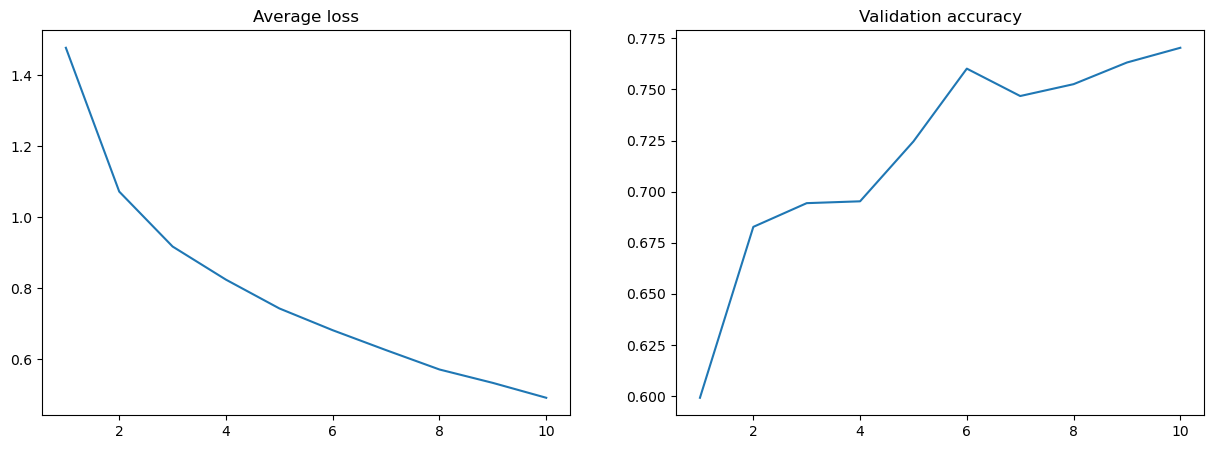

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(np.arange(1, len(avg_test_loss)+1), np.array(avg_test_loss))
axs[0].set_title("Average loss")

axs[1].plot(np.arange(1, len(valid_accs)+1) , np.array(valid_accs))
axs[1].set_title("Validation accuracy")
plt.show()

In [ ]:
net = SmallCNN().to(device)
net.load_state_dict(torch.load("data/models/fedavg_cifar10.pth", weights_only=True))

net.eval()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for (images, labels) in testloader:
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for (images, labels) in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 75 %
Accuracy for class: plane is 78.9 %
Accuracy for class: car   is 88.7 %
Accuracy for class: bird  is 60.4 %
Accuracy for class: cat   is 52.7 %
Accuracy for class: deer  is 75.2 %
Accuracy for class: dog   is 66.3 %
Accuracy for class: frog  is 85.5 %
Accuracy for class: horse is 82.0 %
Accuracy for class: ship  is 85.6 %
Accuracy for class: truck is 84.1 %
